## Imports and Files

In [37]:
# Classic Imports 
import pandas as pd
import numpy as np

import math
import time

# Accessing File Imports 
from pathlib import Path

# Plotting Imports 
from matplotlib import pyplot as plt

# Library FFT Imports 
from scipy.fft import fft, fftfreq

# Custom Imports
from wave_generator import create_wave

# All Relevant Variables 
csv_sampling_frequency = 250000
csv_num_data_points = 16384

is_data_from_sampleData1 = False

### Importing from sampleData1

In [38]:
if (is_data_from_sampleData1 == True):

    # CSV Being Analyzed 
    dataFile = "./sampleData1/1.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), header = None)

    hydrophoneData = load_hydrophone_data()

    def addTime(x): 
        return x / csv_sampling_frequency

    hydrophoneData.columns = ['hydrophone1', 'hydrophone2', 'hydrophone3', 'hydrophone4', 'time'] 
    hydrophoneData["time"] = hydrophoneData["time"].apply(addTime)

    sample = np.array(hydrophoneData["hydrophone1"])
    sampling_frequency = 250000

### Importing from sampleData2

In [39]:
if (is_data_from_sampleData1 == False):

    # CSV Being Analyzed 
    dataFile = "./sampleData2/hydros1_and2_close.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), skiprows = 9)
    
    sample = load_hydrophone_data()

    sample = np.array(sample["Channel 2 (V)"])
    sampling_frequency = 160000

## Data Visualizer 

In [40]:
sample                                  # Gives first couple of lines of the csv

array([4.41207419, 4.41273986, 4.41207419, ..., 4.39842808, 4.41240703,
       4.42106066])

## Temporary Manual Bandpass Filter 

In [41]:
print("The original sample is ")
print(sample)
print("\n")

shift = float(np.mean(sample))

print("This is the shift by which all the values are shifted which is " + str(shift))
print("\n")

sample = sample - shift

print("The shifted and modified sample is + ")
print(sample)

The original sample is 
[4.41207419 4.41273986 4.41207419 ... 4.39842808 4.41240703 4.42106066]


This is the shift by which all the values are shifted which is 4.411266329056753


The shifted and modified sample is + 
[ 0.00080787  0.00147353  0.00080787 ... -0.01283825  0.0011407
  0.00979433]


In [42]:
sample = sample * 100

<AxesSubplot: >

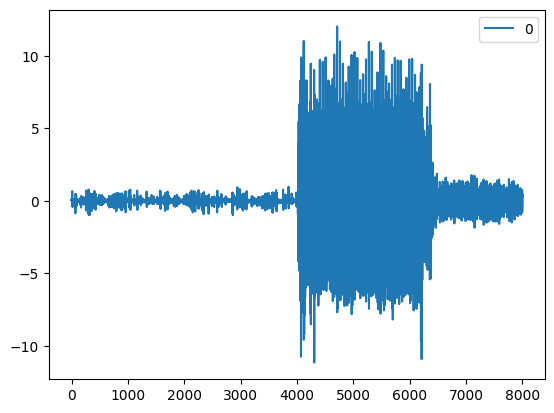

In [43]:
sample1 = sample[0:8000]
sample1 = pd.DataFrame(sample1)

sample1.plot()

## Fourier Transform

In [44]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 200                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 4000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 4200                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

testsample = np.array(sample[startingIndex: endingIndex])

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))

The sampling frequency is 160000
The sample size is 200


Using the scipy library, 200 were analyzed in 0.0001652240753173828 seconds.


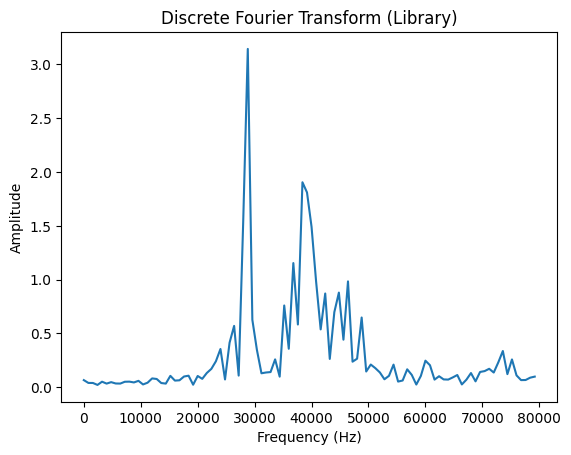

In [45]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(testsample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

## Sliding Fourier Transform for Edge Detection

In [46]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 500                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 0000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 8000                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))
print("The bucket size from the FFT is " + str(sampling_frequency / N))
print("The higheset frequency captured from the FFT is " + str(sampling_frequency / 2))

The sampling frequency is 160000
The sample size is 500
The bucket size from the FFT is 320.0
The higheset frequency captured from the FFT is 80000.0


In [47]:
chosenBucketSize = 400
frequencyToWatch = 35000

sampleNumberArray = []
amplitudeArray = []

for i in range(startingIndex, (endingIndex - N + 1)):

    slidingTestSample = np.array(sample[i: i + N])

    yf = fft(slidingTestSample)
    xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

    frequencies = pd.DataFrame(xf, columns = ["Frequency"])
    amplitudes = pd.DataFrame((2 / N * np.abs(yf[0 : N//2])), columns = ["Amplitude"])

    values = pd.concat([frequencies, amplitudes], axis = 1)

    temp = chosenBucketSize / (sampling_frequency / N)
    index = 0
    newValues = pd.DataFrame(columns = ["Frequency", "Amplitude"])

    currentFrequency = 0
    currentAmplitude = 0

    for j in range(values.shape[0]):
        currentAmplitude = currentAmplitude + values["Amplitude"][j]
    
        if (index == 0):
            currentFrequency = values["Frequency"][j]
        
        index = index + 1

        if (index == temp):
            tempRowDictionary = {"Frequency": currentFrequency, "Amplitude": currentAmplitude}
            tempdf = pd.DataFrame([tempRowDictionary])
            newValues = pd.concat([newValues, tempdf], axis = 0, ignore_index = True)

            currentAmplitude = 0
            index = 0
    

    sampleNumberArray.append(i)
    amplitudeArray.append((newValues.loc[newValues['Frequency'] == frequencyToWatch]).iloc[0, 1])

for i in range(len(sampleNumberArray)):
    print(str(sampleNumberArray[i]) + "\t\t" + str(amplitudeArray[i]))

IndexError: index 0 is out of bounds for axis 0 with size 0

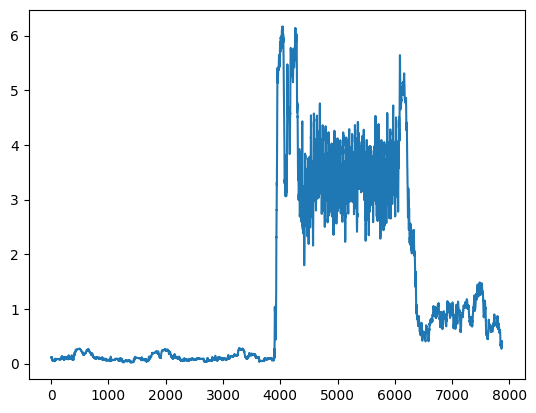

In [ ]:
plt.plot(sampleNumberArray, amplitudeArray)

Using the scipy library, 128 were analyzed in 0.0006530284881591797 seconds.


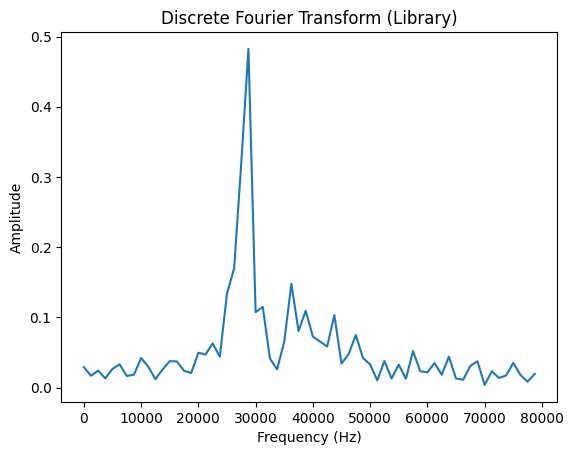

In [ ]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(slidingTestSample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

In [ ]:
pd.DataFrame(xf)
pd.DataFrame()

""


## Data Viewed in Detail

### Original Data

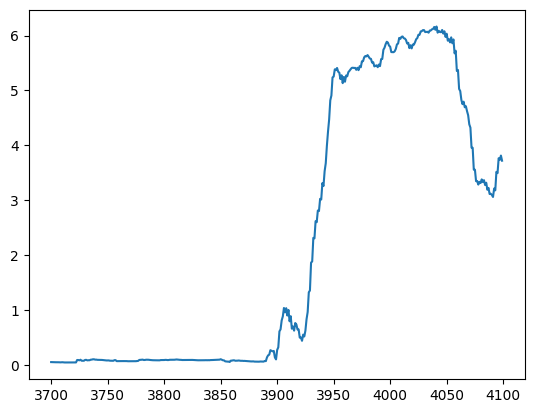

In [ ]:
plt.plot(sampleNumberArray[3700:4100], amplitudeArray[3700:4100])

### DFT Data

<AxesSubplot: >

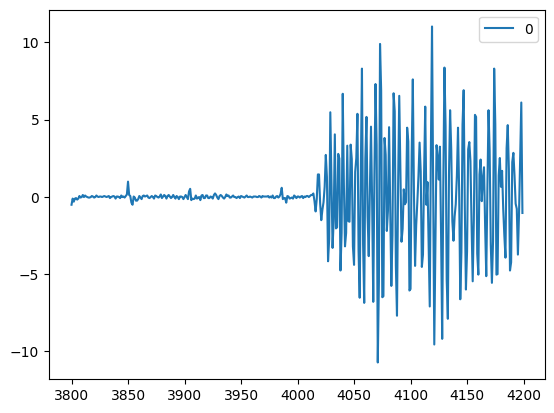

In [ ]:
sample1[3800:4200].plot()

## Edge Detection

In [ ]:
amplitudeArray[0:2500]

[0.10862325874202185,
 0.1086844704906436,
 0.11112632324196371,
 0.11281005894738973,
 0.1153584868444236,
 0.11360289462227069,
 0.11475010343045441,
 0.11600274082294701,
 0.11779173550670431,
 0.1146822054580785,
 0.11584317597975965,
 0.11760259892275617,
 0.11752345567243037,
 0.08427928800688922,
 0.08562599812537947,
 0.07151556803796463,
 0.06428327745121515,
 0.06223492488820169,
 0.06313731401748589,
 0.061330064908611856,
 0.05510267958198668,
 0.05381838888658204,
 0.05357151356318672,
 0.05321109927395487,
 0.053376776846652665,
 0.053376776846652665,
 0.05444363278214712,
 0.054321433015747725,
 0.054797757462263195,
 0.05544542736789383,
 0.05544542736789495,
 0.05857137331383129,
 0.05861817206485336,
 0.05930022197330839,
 0.0619445537666585,
 0.05870663185041155,
 0.05408917160315245,
 0.05358534255281672,
 0.05259350001458786,
 0.05400117842451031,
 0.05642023356067555,
 0.057175342838920354,
 0.05598540292204601,
 0.04566060914288304,
 0.05231891118057113,
 0.04735

In [ ]:
threshold = np.mean(amplitudeArray[0:2500])
threshold = np.percentile(amplitudeArray[0:2500], 90)
threshold = threshold * 2
print(threshold)

0.4664406910889823


In [ ]:
flag = False
edgeStart = 0

for i in range(0, len(amplitudeArray)):
    if (flag == False):
        if (amplitudeArray[i] > threshold):
            edgeStart = i
            flag = True

print("The start of the edge is " + str(edgeStart))

The start of the edge is 3902


/var/folders/lc/pglrvvjx68x0bqm9722f1brr0000gn/T/ipykernel_20822/2268994605.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


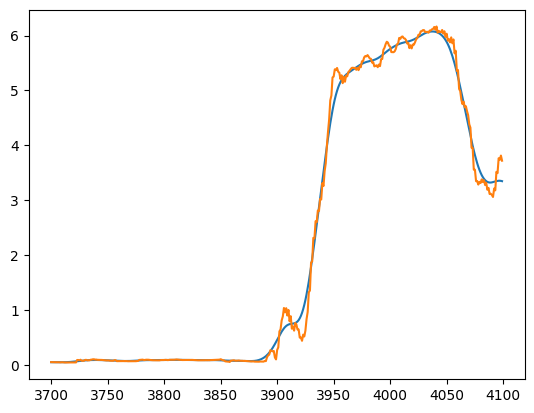

In [ ]:
from scipy.ndimage.filters import gaussian_filter

gaussFiltered = gaussian_filter(amplitudeArray, sigma=7)

plt.plot(sampleNumberArray[3700:4100], gaussFiltered[3700:4100])
plt.plot(sampleNumberArray[3700:4100], amplitudeArray[3700:4100])
#plt.plot(sampleNumberArray, amplitudeArray)
#plt.plot(sampleNumberArray, gaussFiltered)
